# Car Insurance Claims - Process Mining & Anomaly Detection

## 1. Data Cleaning


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [4]:
# Load the dataset
file_path = "/content/drive/MyDrive/SAP/Insurance_claims_event_log.csv"
df = pd.read_csv(file_path)

# Display basic info
df.info()

# Display first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   case_id           180000 non-null  object 
 1   activity_name     180000 non-null  object 
 2   timestamp         180000 non-null  object 
 3   claimant_name     180000 non-null  object 
 4   agent_name        180000 non-null  object 
 5   adjuster_name     180000 non-null  object 
 6   claim_amount      180000 non-null  float64
 7   claimant_age      180000 non-null  int64  
 8   type_of_policy    180000 non-null  object 
 9   car_make          180000 non-null  object 
 10  car_model         180000 non-null  object 
 11  car_year          180000 non-null  int64  
 12  type_of_accident  180000 non-null  object 
 13  user_type         180000 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 19.2+ MB


,case_id,activity_name,timestamp,claimant_name,agent_name,adjuster_name,claim_amount,claimant_age,type_of_policy,car_make,car_model,car_year,type_of_accident,user_type
0,a626bc58-a7b2-4eff-aca9-2a622cd0c492,First Notification of Loss (FNOL),2020-09-24 14:08:42.423530,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
1,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Assign Claim,2020-10-13 03:51:28.627923,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
2,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Claim Decision,2020-10-14 22:30:14.948970,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
3,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Set Reserve,2020-10-24 11:49:39.053890,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
4,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Payment Sent,2020-10-27 05:46:04.378718,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA


In [5]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Check for missing values and data types
missing_values = df.isnull().sum()
data_types = df.dtypes

# Summary statistics
summary_statistics = df.describe()

# Unique values in categorical columns
categorical_columns = ['activity_name', 'claimant_name', 'agent_name', 'adjuster_name', 'type_of_policy', 'car_make', 'car_model', 'type_of_accident', 'user_type']
unique_values = {col: df[col].nunique() for col in categorical_columns}

# Display results
missing_values, data_types, summary_statistics, unique_values


(case_id             0
 activity_name       0
 timestamp           0
 claimant_name       0
 agent_name          0
 adjuster_name       0
 claim_amount        0
 claimant_age        0
 type_of_policy      0
 car_make            0
 car_model           0
 car_year            0
 type_of_accident    0
 user_type           0
 dtype: int64,
 case_id                     object
 activity_name               object
 timestamp           datetime64[ns]
 claimant_name               object
 agent_name                  object
 adjuster_name               object
 claim_amount               float64
 claimant_age                 int64
 type_of_policy              object
 car_make                    object
 car_model                   object
 car_year                     int64
 type_of_accident            object
 user_type                   object
 dtype: object,
                            timestamp   claim_amount   claimant_age  \
 count                         180000  180000.000000  180000.000000   
 

## 2. Exploratory Data Analysis
Analyzing the distribution of claims over time (monthly, yearly trends).

Identify peak periods for claims.

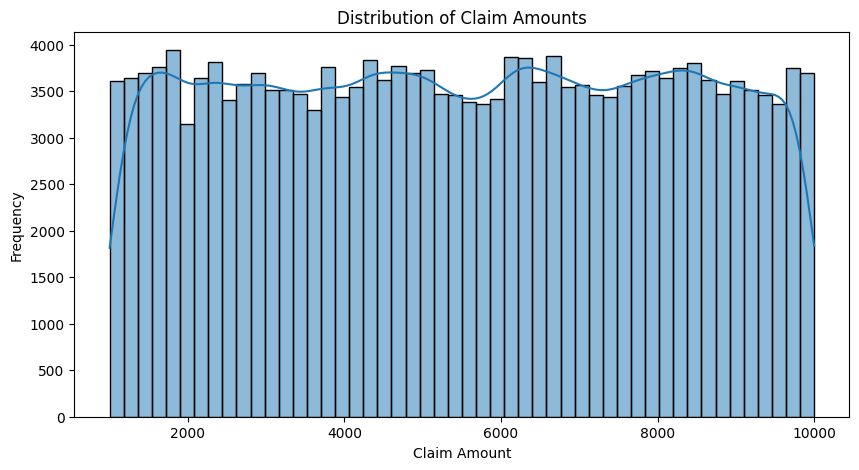

<Figure size 1200x600 with 0 Axes>

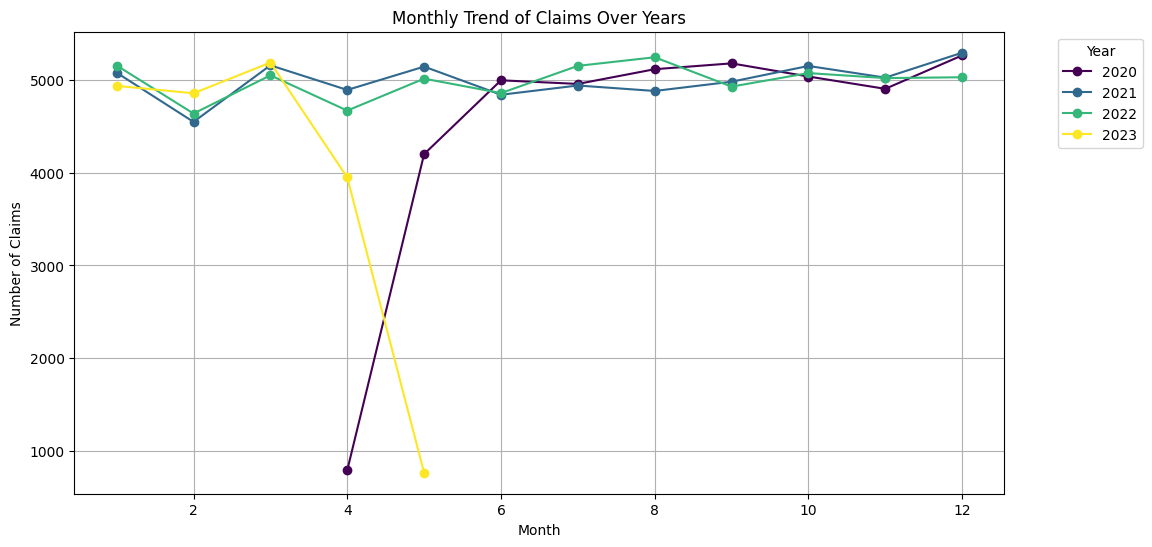

In [6]:
# Visualization: Distribution of claim amounts
plt.figure(figsize=(10,5))
sns.histplot(df['claim_amount'], bins=50, kde=True)
plt.title('Distribution of Claim Amounts')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.show()

# Extract year and month
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Group by year and month
claims_per_month = df.groupby(['year', 'month']).size().unstack()

# Plot the monthly trend
plt.figure(figsize=(12, 6))
claims_per_month.T.plot(marker='o', figsize=(12, 6), colormap='viridis')
plt.xlabel("Month")
plt.ylabel("Number of Claims")
plt.title("Monthly Trend of Claims Over Years")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


### Monthly Claim Trends (2020-2023) - Key Observations

#### General Trend Stability
- For most years (**2021** and **2022**), the number of claims per month remains relatively stable, fluctuating slightly around the **5000** mark.

#### Anomalies in 2020 and 2023
- **2020**: The number of claims drops sharply in **April** but quickly recovers by **June**.  
  - This could indicate a major external event affecting claim filings (e.g., **pandemic-related lockdowns**).  
- **2023**: The trend is normal until **April**, but after that, there is a **steep decline**, with an extreme drop in **May**.  
  - This is unusual and might suggest **missing data**, a **reporting issue**, or an **external disruption** affecting claim processing.

#### Seasonality Not Evident
- Unlike some industries where claims peak in certain months (e.g., **winter for car accidents**), there is **no clear seasonal pattern** across the years.

---


#### Claim Processing Time Analysis
Calculate the time taken between different activity stages.

Identify delays in the claims process.

<ipython-input-7-526553a7aab3>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Stage Transition", y="Days", data=df_melted, palette="viridis")


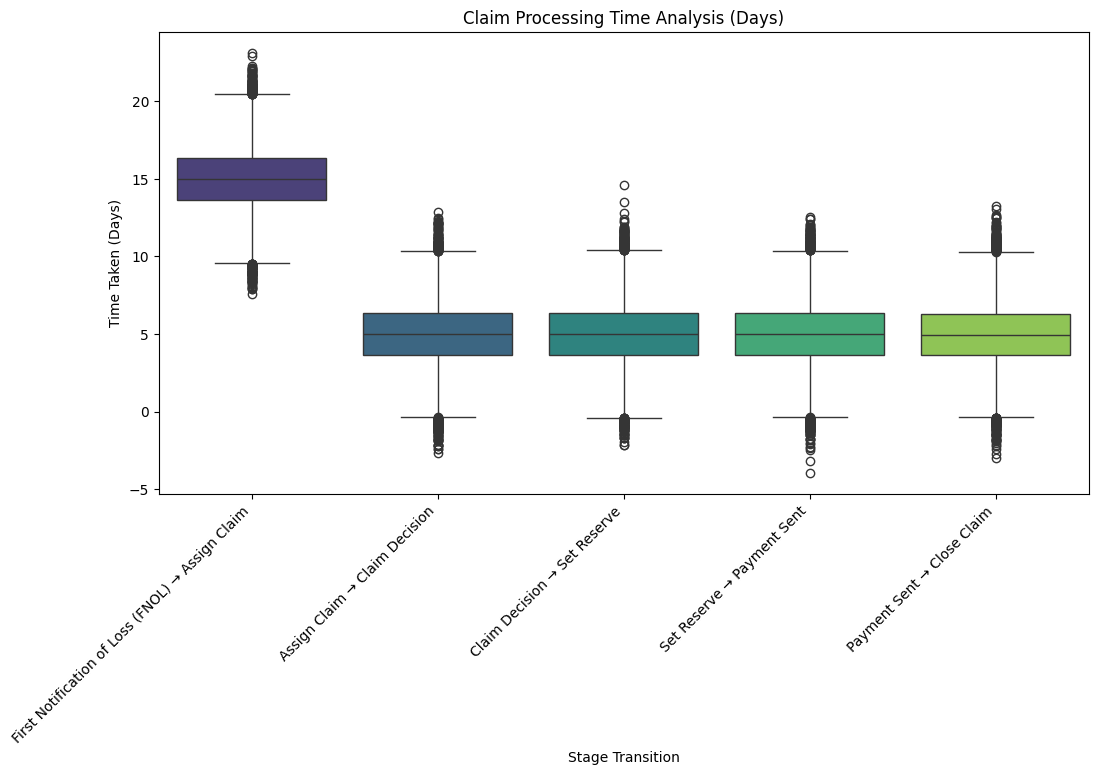

In [7]:
# Sort by case_id and timestamp
#df = df.sort_values(by=['case_id', 'timestamp'])

# Define process stages in order
process_flow = [
    "First Notification of Loss (FNOL)",
    "Assign Claim",
    "Claim Decision",
    "Set Reserve",
    "Payment Sent",
    "Close Claim"
]

# Pivot data to get timestamps for each stage per case
df_pivot = df.pivot(index="case_id", columns="activity_name", values="timestamp")

# Calculate time differences between each stage
for i in range(len(process_flow) - 1):
    df_pivot[f"{process_flow[i]} → {process_flow[i+1]}"] = (
        df_pivot[process_flow[i+1]] - df_pivot[process_flow[i]]
    ).dt.total_seconds() / 86400  # Convert seconds to days

# Drop original timestamps
df_pivot = df_pivot.drop(columns=process_flow)

# Melt for visualization
df_melted = df_pivot.reset_index().melt(id_vars=["case_id"], var_name="Stage Transition", value_name="Days")

# Plot distribution of time taken between stages
plt.figure(figsize=(12, 6))
sns.boxplot(x="Stage Transition", y="Days", data=df_melted, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Claim Processing Time Analysis (Days)")
plt.xlabel("Stage Transition")
plt.ylabel("Time Taken (Days)")
plt.show()


### Insights from the Visualization

#### FNOL → Assign Claim Takes the Longest Time
- The median processing time for **First Notification of Loss (FNOL) → Assign Claim** is significantly higher (~15 days) compared to other transitions.
- The spread is also quite large, with some cases taking over 20 days.
- This indicates a potential bottleneck in the claim assignment process.

#### Other Stages Have Relatively Shorter and Consistent Durations
- The median processing times for **Assign Claim → Claim Decision**, **Claim Decision → Set Reserve**, **Set Reserve → Payment Sent**, and **Payment Sent → Close Claim** are all fairly close (~5 days).
- The interquartile range (IQR) is smaller, meaning these steps are more predictable and efficient compared to **FNOL → Assign Claim**.

#### Presence of Outliers in All Stages
- There are outliers in every stage, with some cases taking significantly longer.
- This could be due to complex claims, missing documentation, or manual review delays.

### Recommendations for Process Improvement

#### Investigate Delays in FNOL → Assign Claim
- Could be due to manual verification, backlog, or inefficient routing.
- Automation or optimized workflows could reduce time here.

#### Analyze Outliers in Each Stage
- Identify specific cases that took unusually long and find root causes.

#### Compare Processing Times Across Claim Types
- Further breakdown by claim type, policy type, or adjuster can provide deeper insights into efficiency variations.


#### Correlation Analysis
Finding correlations between claim amount and type of accident.

ANOVA results for Type of Accident & Claim Amount: p-value = 0.3598080829450331


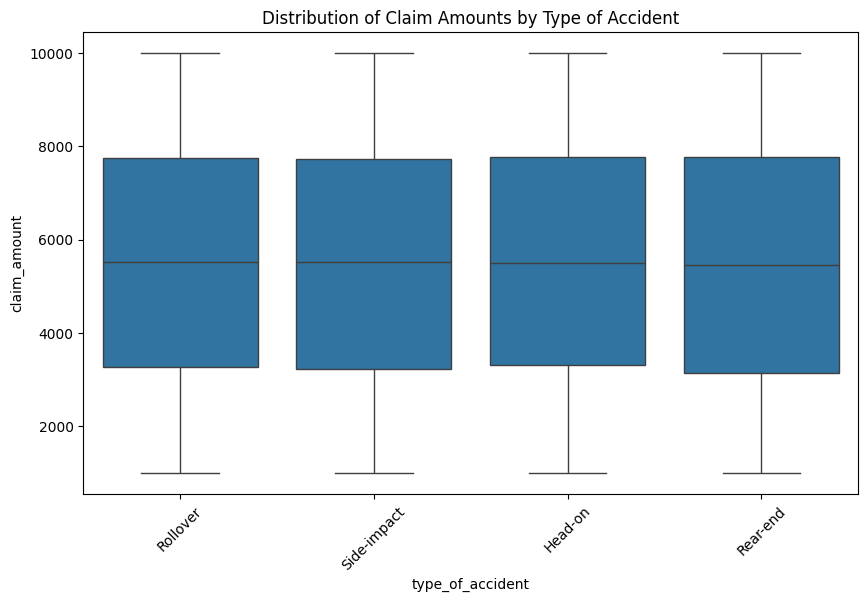

In [8]:
# Perform ANOVA test
anova_accident = stats.f_oneway(*(df["claim_amount"][df["type_of_accident"] == accident] for accident in df["type_of_accident"].unique()))

print(f"ANOVA results for Type of Accident & Claim Amount: p-value = {anova_accident.pvalue}")

plt.figure(figsize=(10, 6))
sns.boxplot(x="type_of_accident", y="claim_amount", data=df)
plt.xticks(rotation=45)
plt.title("Distribution of Claim Amounts by Type of Accident")
plt.show()


# 3. Anomaly detection
### Statistical Method

In [9]:

df["timestamp"] = pd.to_datetime(df["timestamp"])

# Compute delay between stages
df = df.sort_values(by=["case_id", "timestamp"])
df["delay_between_stages"] = df.groupby("case_id")["timestamp"].diff().dt.days


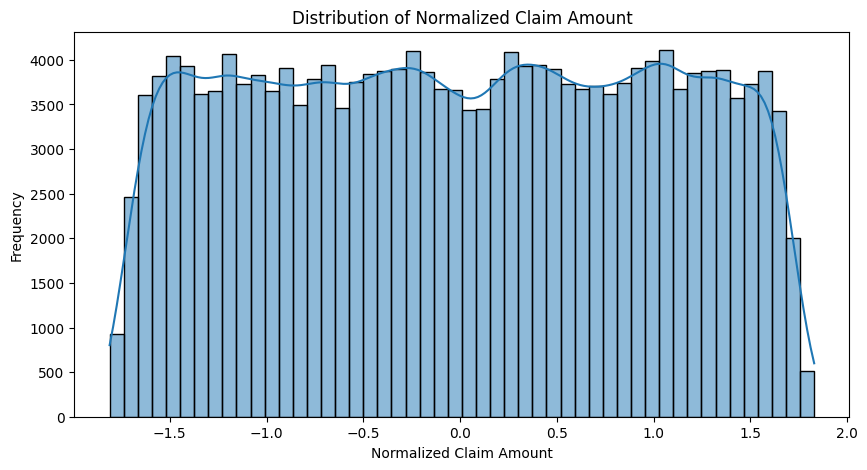

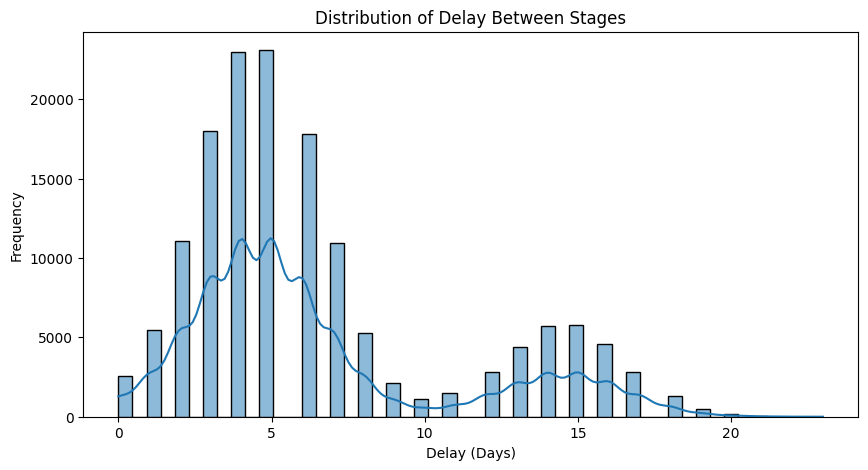

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize Claim Amount by Car Year and Accident Type
df["claim_amount_norm"] = df.groupby(["car_year", "type_of_accident"])["claim_amount"].transform(lambda x: (x - x.mean()) / x.std())

# Plot histogram for Normalized Claim Amount
plt.figure(figsize=(10, 5))
sns.histplot(df["claim_amount_norm"].dropna(), bins=50, kde=True)
plt.title("Distribution of Normalized Claim Amount")
plt.xlabel("Normalized Claim Amount")
plt.ylabel("Frequency")
plt.show()

# Plot histogram for Delay Between Stages
plt.figure(figsize=(10, 5))
sns.histplot(df["delay_between_stages"].dropna(), bins=50, kde=True)
plt.title("Distribution of Delay Between Stages")
plt.xlabel("Delay (Days)")
plt.ylabel("Frequency")
plt.show()


In [11]:
file_path = "/content/drive/MyDrive/SAP/Insurance_claims_event_log.csv"
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Calculate delays between stages
df = df.sort_values(by=["case_id", "timestamp"])
df["delay_between_stages"] = df.groupby("case_id")["timestamp"].diff().dt.days

# Normalize Claim Amount by Car Year and Accident Type
df["claim_amount_norm"] = df.groupby(["car_year", "type_of_accident"])["claim_amount"].transform(lambda x: (x - x.mean()) / x.std())

# Z-Score for detecting anomalies in claim amounts
df["claim_z_score"] = zscore(df["claim_amount_norm"])
df["anomalous_claim_amount"] = df["claim_z_score"].abs() > 3

# IQR Method for detecting anomalies in processing delays
Q1 = df["delay_between_stages"].quantile(0.25)
Q3 = df["delay_between_stages"].quantile(0.75)
IQR = Q3 - Q1
df["anomalous_delay"] = (df["delay_between_stages"] < (Q1 - 1.5 * IQR)) | (df["delay_between_stages"] > (Q3 + 1.5 * IQR))

# Print anomalies in Claim Amount
print("Anomalies in Claim Amount:")
print(df[df["anomalous_claim_amount"]][["case_id", "claim_amount", "car_year", "type_of_accident"]])

# Print anomalies in Processing Delays
print("\nAnomalies in Processing Delays:")
print(df[df["anomalous_delay"]][["case_id", "delay_between_stages"]])



Anomalies in Claim Amount:
Empty DataFrame
Columns: [case_id, claim_amount, car_year, type_of_accident]
Index: []

Anomalies in Processing Delays:
                                     case_id  delay_between_stages
56479   000771f4-d1b6-4d3e-a81b-31b792d1a98c                  18.0
38347   000bb4cc-ee97-4e5a-8a8e-ac2cca9c3569                  15.0
52249   000c42da-1781-4faa-96cc-dac76d35ef04                  16.0
125389  000f1f69-8808-445d-8339-33de46ea2f7a                  16.0
100279  0014d7d8-fe2a-43d8-8b13-109cb93c5296                  17.0
...                                      ...                   ...
146263  ffe744aa-6fb9-410e-98c4-245af05a1432                  15.0
163669  ffed78a5-aa83-41ca-9e1c-576a7bd28683                  17.0
45649   fff3858f-47d9-40b8-9847-b98a4436dc2a                  16.0
125377  fff8ae66-b0e6-4db0-80fe-8788626cee99                  15.0
178183  fffb4dea-5d95-4dcc-9a99-282595614167                  18.0

[15084 rows x 2 columns]


In [12]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Select relevant features
features = ["claim_amount", "car_year", "delay_between_stages", "claimant_age"]
df_filtered = df.dropna(subset=features).copy()

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered.loc[:, "cluster"] = kmeans.fit_predict(X_scaled)

# Identify outliers using smallest cluster
outlier_cluster = df_filtered["cluster"].value_counts().idxmin()
df_filtered.loc[:, "anomalous_kmeans"] = df_filtered["cluster"] == outlier_cluster

# Apply DBSCAN on full dataset
dbscan = DBSCAN(eps=0.3, min_samples=3)
df_filtered.loc[:, "anomalous_dbscan"] = dbscan.fit_predict(X_scaled) == -1

# Apply One-Class SVM
svm_model = OneClassSVM(kernel="rbf", gamma="auto", nu=0.05)
df_filtered.loc[:, "anomalous_svm"] = svm_model.fit_predict(X_scaled) == -1

# Print anomalies detected by each method
print("K-Means Anomalies:")
print(df_filtered[df_filtered["anomalous_kmeans"]][["case_id", "claim_amount", "car_year", "delay_between_stages", "claimant_age", "cluster"]])

print("\nDBSCAN Anomalies:")
print(df_filtered[df_filtered["anomalous_dbscan"]][["case_id", "claim_amount", "car_year", "delay_between_stages", "claimant_age"]])

print("\nSVM Anomalies:")
print(df_filtered[df_filtered["anomalous_svm"]][["case_id", "claim_amount", "car_year", "delay_between_stages", "claimant_age"]])


K-Means Anomalies:
                                     case_id  claim_amount  car_year  \
75955   000112d5-9d04-450f-820f-3edfc0626cf9       9266.19      2021   
153037  0001c62c-696c-4251-a604-8d319fc73fac       4636.30      2012   
165181  00048c02-65b5-423b-bf38-139a099a5624       4897.70      2011   
33967   0005b367-5a31-4bcd-82f3-05103f43b462       9596.03      2017   
18283   000694f5-9a75-4885-ab77-7842d78188ae       7181.00      2017   
...                                      ...           ...       ...   
43711   ffea488c-eaa1-48eb-b826-a6af9a224b8e       1949.06      2010   
163669  ffed78a5-aa83-41ca-9e1c-576a7bd28683       2269.93      2015   
45649   fff3858f-47d9-40b8-9847-b98a4436dc2a       9941.74      2016   
125377  fff8ae66-b0e6-4db0-80fe-8788626cee99       6228.75      2012   
178183  fffb4dea-5d95-4dcc-9a99-282595614167       5143.61      2011   

        delay_between_stages  claimant_age  cluster  
75955                   12.0            60        2  
153037  

In [13]:
!pip install tensorflow


In [14]:
!pip install tensorflow[and-cuda]


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare Data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define Autoencoder
input_dim = X_train.shape[1]
autoencoder = keras.Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(input_dim, activation="linear")
])

autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Compute Reconstruction Error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse, 95)
df_filtered["anomalous_autoencoder"] = mse > threshold

# Display anomalies
print(df_filtered[df_filtered["anomalous_autoencoder"]])


Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1549 - val_loss: 5.3731e-05
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.1427e-05 - val_loss: 6.4485e-06
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.0278e-05 - val_loss: 7.7450e-06
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.1795e-05 - val_loss: 1.0371e-05
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.7329e-06 - val_loss: 7.0667e-06
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 7.5833e-06 - val_loss: 1.1736e-05
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.0257e-05 - val_loss: 8.6010e-06
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 8.0434e-06 - val_loss: 5.6763e-06
Epoch 9/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6.8207e-06 - val_loss: 1.5458e-07
Epoch 10/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.8326e-06 - val_loss: 2.1238e-05
Epoch 11/20
3750/3750 ━━━━━━━━━━━

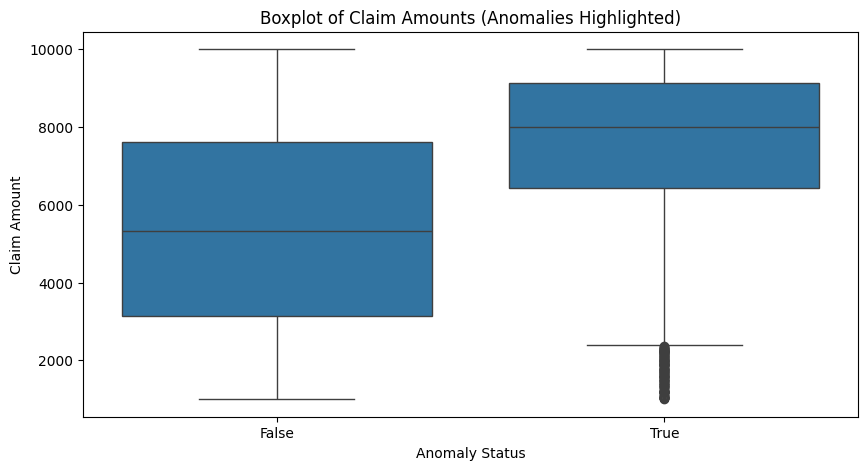

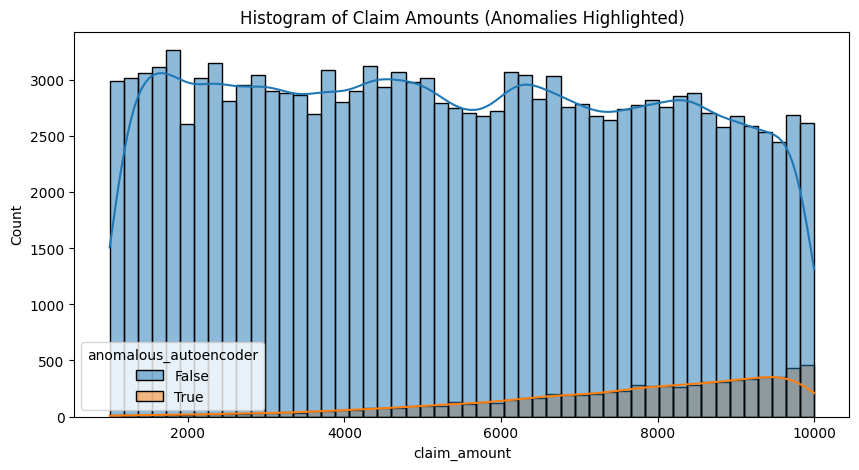

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


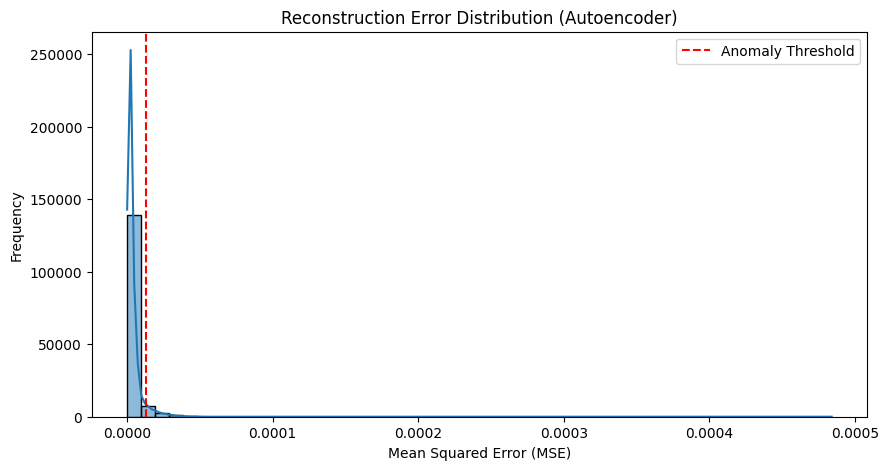

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean MSE (Normal Samples): nan
Mean MSE (Anomalous Samples): 3.796298556888535e-06
Silhouette Score for K-Means Clustering: 0.22259753268665503


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Ensure 'anomalous_autoencoder' exists in df_filtered before running
if "anomalous_autoencoder" not in df_filtered.columns:
    raise ValueError("Column 'anomalous_autoencoder' not found in df_filtered.")

# Convert 'anomalous_autoencoder' to categorical for visualization
df_filtered["anomalous_autoencoder"] = df_filtered["anomalous_autoencoder"].astype(str)

### 1. Boxplots to visualize anomalies
plt.figure(figsize=(10, 5))
sns.boxplot(x="anomalous_autoencoder", y="claim_amount", data=df_filtered)
plt.title("Boxplot of Claim Amounts (Anomalies Highlighted)")
plt.xlabel("Anomaly Status")
plt.ylabel("Claim Amount")
plt.show()

### 2. Histogram of claim amounts with anomalies highlighted
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered, x="claim_amount", bins=50, kde=True, hue="anomalous_autoencoder")
plt.title("Histogram of Claim Amounts (Anomalies Highlighted)")
plt.show()

### 3. Reconstruction Error Analysis (Autoencoder)
reconstructions = autoencoder.predict(X_scaled)
mse_values = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(mse_values, bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="dashed", label="Anomaly Threshold")
plt.title("Reconstruction Error Distribution (Autoencoder)")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 4. Mean Squared Error (MSE) Comparison
normal_mse = mse_values[~df_filtered["anomalous_autoencoder"].astype(bool)]
anomalous_mse = mse_values[df_filtered["anomalous_autoencoder"].astype(bool)]

print(f"Mean MSE (Normal Samples): {np.mean(normal_mse)}")
print(f"Mean MSE (Anomalous Samples): {np.mean(anomalous_mse)}")

### 5. Silhouette Score for Clustering Performance
scaler = StandardScaler()
X_scaled_cluster = scaler.fit_transform(df_filtered[["claim_amount", "car_year", "delay_between_stages", "claimant_age"]])

kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered["cluster"] = kmeans.fit_predict(X_scaled_cluster)

silhouette_avg = silhouette_score(X_scaled_cluster, df_filtered["cluster"])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg}")
